In [2]:
import numpy as np
import pandas as pd
import cv2
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import random

Importing the dataset containing the images:

In [3]:
dataset = glob.glob('IDC_regular_ps50_idx5/**/*.png',recursive = True)

In [4]:
print(len(dataset))

277524


Checking the dataset to see if images are fine:

Splitting the dataset into 'positive' and 'negative'.  For this dataset, the fifth character from the end of the image name will signify '0' (negative) or '1' (positive).

In [5]:
negative = []
positive = []

for img in dataset:
    if img[-5] == '0':
        negative.append(img)
        
    elif img[-5] == '1':
        positive.append(img)

In [6]:
print(len(negative))
print(len(positive))

198738
78786


Obtaining sample images of each class to check the dataset. These are in the form of numbers which will correspond to that image.

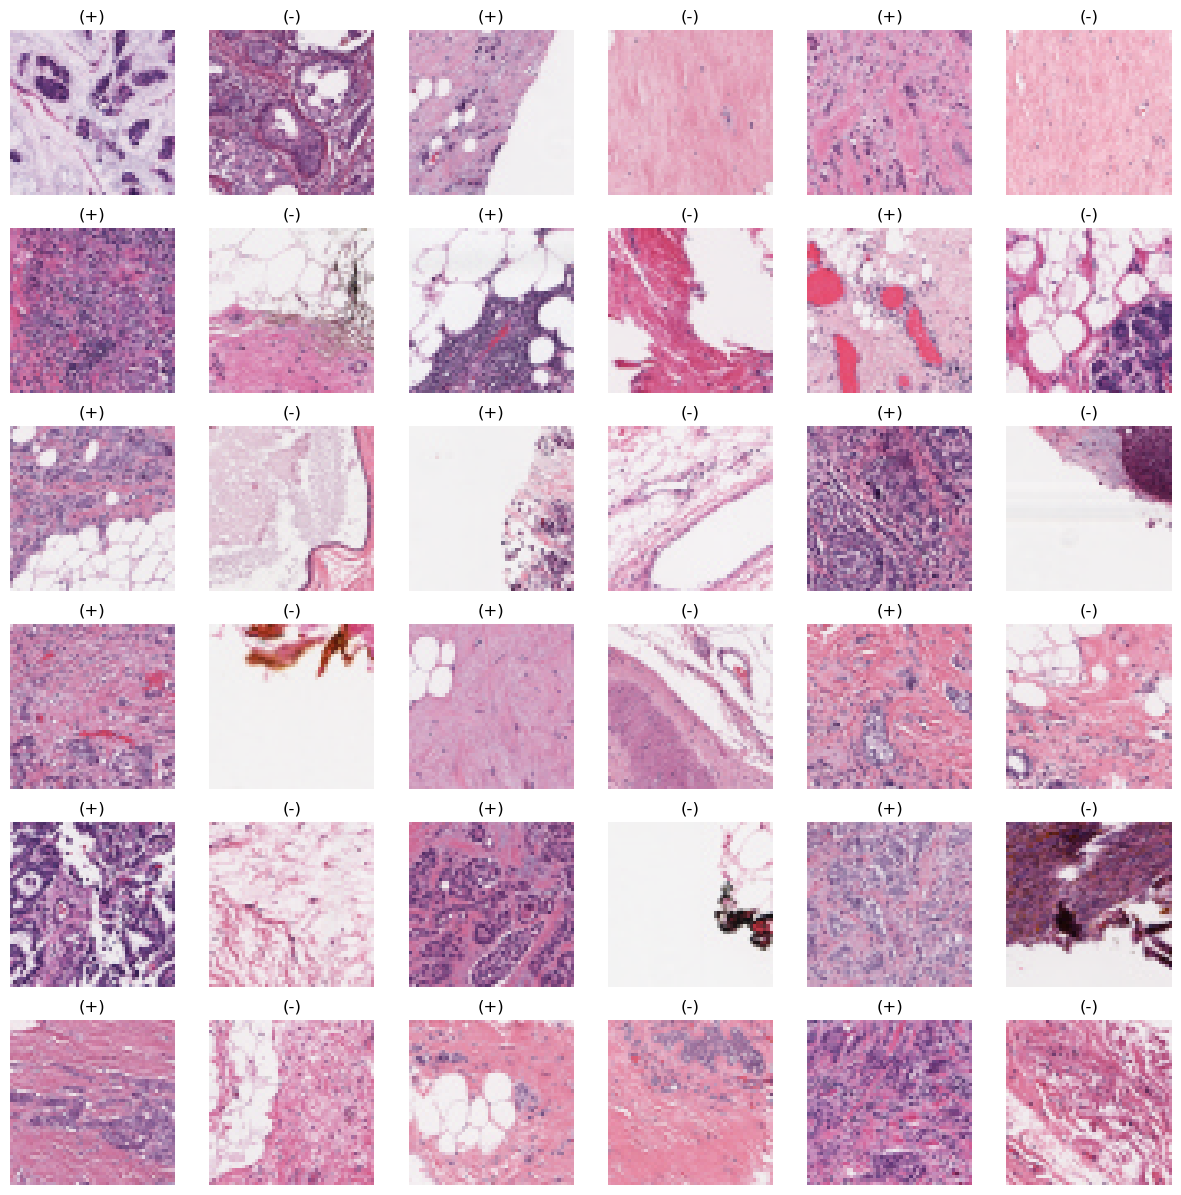

In [7]:
sample_negatives = np.random.randint(0,len(negative),18)
sample_positives = np.random.randint(0,len(positive),18)  # np.random.randint(low,high,size)

plt.figure(figsize=(15,15)) #sets the size of the image to 15x15

i = 0 

for n in sample_positives:
    img = tf.keras.utils.load_img((positive[n])) #loads the image corresponding to n in 'positive'-> tf.keras.utils.load_img(path)
    img = tf.keras.utils.img_to_array(img) #converts the image into a numpy array -> tf.keras.utils.img_to_array(image_name)
    
    plt.subplot(6,6,2*i + 1) 
    
    #plt.subplot(row,column,index) creates multiple plots in a single plot. Here, many images are being displayed in a single plot.
    #row-tells how many rows to display, column-tells how many columns to display, index-index of the image to be displayed
    
    plt.axis('off')
    plt.title('(+)') #sets the title for the image
    plt.imshow(img.astype('uint8'))
    
    i+=1
    
i = 1

for n in sample_negatives:
    img = tf.keras.utils.load_img((negative[n]))
    img = tf.keras.utils.img_to_array(img)
    
    plt.subplot(6,6,2*i)
    plt.axis('off')
    plt.title('(-)')
    plt.imshow(img.astype('uint8'))
    
    i+=1


Preprocessing:

The number of negatives in the dataset is much larger compared to the number of positives. This will cause a bias in the model leading to inaccuracies. A new set with the number of negatives being the same as the number of positives has to be created.

In [8]:
shortened_negative = negative[:78786]
print(len(shortened_negative))
print(len(positive))

78786
78786


The image along with it's class is grouped and put into an array.

In [9]:
image_class_set = []

for i in shortened_negative:
    img = cv2.imread(i,cv2.IMREAD_COLOR) 
    
    #cv2.imread(img_name) loads the image, and returns a tensor corresponding to that image
    #cv2.IMREAD_COLOR reads the image in BGR format
    
    img = cv2.resize(img,(50,50),interpolation = cv2.INTER_LINEAR) #cv2.resize(image,dim,interpolation = __), cv2.INTER_LINEAR for when zooming is required
    image_class_set.append([img,0])
    
for i in positive:
    img = cv2.imread(i,cv2.IMREAD_COLOR)
    img = cv2.resize(img,(50,50),interpolation = cv2.INTER_LINEAR)
    image_class_set.append([img,1])

In [10]:
print(len(image_class_set))

157572


The array is the shuffled to make it random

In [11]:
random.shuffle(image_class_set)

The array is then split into independent (x) and dependent (y) sets

In [12]:
x = []
y = []

for feature,label in image_class_set:
    x.append(feature)
    y.append(label)

x = np.array(x)
y = np.array(y)

Splitting into training and testing sets

In [13]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state = 0)

y_train = tf.keras.utils.to_categorical(y_train,num_classes = 2) #one hot encoding
y_test = tf.keras.utils.to_categorical(y_test,num_classes = 2)

Building and Training:

Importing necessary libraries to construct the model

In [14]:
from tensorflow.keras import layers,models,losses,optimizers
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization

Building the model

In [15]:
terminate=EarlyStopping(monitor='val_loss',patience=5) #stops after 'monitor' has stopped improving over 'patience' amount of epochs

model = models.Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 3)))
model.add(BatchNormalization()) #normalizes the input to the next layer

model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3)) #removes overfitting

model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())

model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(24, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(2, activation='softmax'))

Summary of the model's architecture

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 50, 50, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 25, 25, 32)        0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 25, 25, 32)        128       
 chNormalization)                                                
                                                        

In [17]:
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

Training the model on the training set. This is done for 11 epochs

In [18]:
pred = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 11, batch_size = 35)

Epoch 1/11
3152/3152 [==============================] - 923s 291ms/step - loss: 0.4058 - accuracy: 0.8263 - val_loss: 0.3601 - val_accuracy: 0.8423
Epoch 2/11
3152/3152 [==============================] - 997s 316ms/step - loss: 0.3427 - accuracy: 0.8541 - val_loss: 0.3237 - val_accuracy: 0.8668
Epoch 3/11
3152/3152 [==============================] - 926s 294ms/step - loss: 0.3171 - accuracy: 0.8684 - val_loss: 0.3178 - val_accuracy: 0.8627
Epoch 4/11
3152/3152 [==============================] - 835s 265ms/step - loss: 0.3043 - accuracy: 0.8732 - val_loss: 0.2944 - val_accuracy: 0.8771
Epoch 5/11
3152/3152 [==============================] - 859s 272ms/step - loss: 0.2924 - accuracy: 0.8773 - val_loss: 0.2683 - val_accuracy: 0.8898
Epoch 6/11
3152/3152 [==============================] - 853s 271ms/step - loss: 0.2812 - accuracy: 0.8828 - val_loss: 0.2816 - val_accuracy: 0.8851
Epoch 7/11
3152/3152 [==============================] - 848s 269ms/step - loss: 0.2732 - accuracy: 0.8869 - val_

Analysis of metrics and preformance of the model:

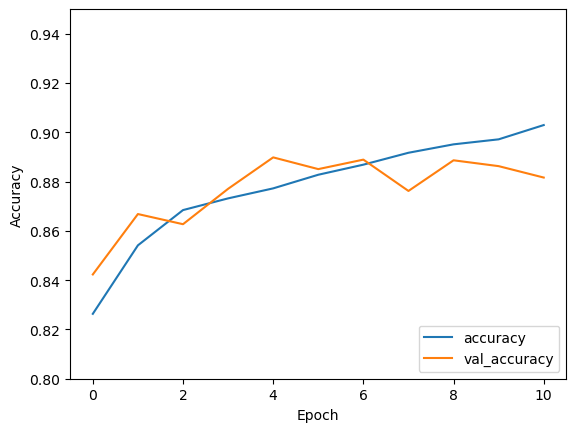

In [19]:
plt.plot(pred.history['accuracy'], label='accuracy')
plt.plot(pred.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.8, 0.95])
plt.legend(loc='lower right')
plt.show()

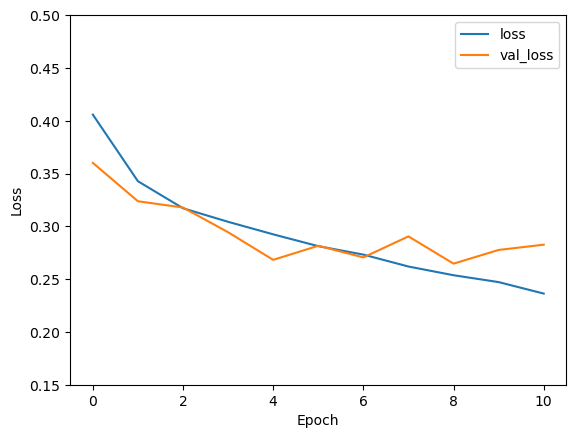

In [20]:
plt.plot(pred.history['loss'], label='loss')
plt.plot(pred.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.15, 0.5])
plt.legend(loc='upper right')
plt.show()

Evaluating the model and printing the confusion matrix and classification report

In [21]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

1478/1478 - 90s - loss: 0.2826 - accuracy: 0.8816 - 90s/epoch - 61ms/step


In [22]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1) 

cm = confusion_matrix(y_true, y_pred) 
print(cm)

1478/1478 [==============================] - 103s 69ms/step
[[19810  3895]
 [ 1700 21867]]


In [23]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88     23705
           1       0.85      0.93      0.89     23567

    accuracy                           0.88     47272
   macro avg       0.88      0.88      0.88     47272
weighted avg       0.88      0.88      0.88     47272

